# TechQuake: Behavior of Major Tech Stocks During Market Shocks

This notebook explores the behavior of selected technology-related stocks:

- AAPL (Apple)
- MSFT (Microsoft)
- NVDA (Nvidia)
- AMZN (Amazon)
- SPOT (Spotify)

Using daily price data from Yahoo Finance (`yfinance`), the notebook:

1. Fetches historical price data for the selected tickers.
2. Cleans and transforms the data using helper functions in `stock_data/`.
3. Computes daily returns, cumulative returns (indexed to 100), rolling volatility, and drawdowns.
4. Visualizes performance and risk, with an emphasis on market shocks such as the COVID-19 period and the 2022 inflation-driven selloff.

The goal is to compare how different tech companies behave under stress, both in terms of long-term growth and downside risk.

In [1]:
# Add the parent directory to the system path for proper module imports
import sys
sys.path.append("..")

In [2]:
# Project imports: data loading, processing, and plotting
from stock_data.fetch_data import fetch_stock_data
from stock_data.process_data import (
    extract_price_table,
    compute_daily_returns,
    compute_cumulative_returns,
    compute_rolling_volatility,
    compute_drawdowns,
)
from stock_data.visualizations import (
    plot_cumulative_returns,
    plot_stock_comparison,
    plot_volatility_with_events,
)

from datetime import datetime

## Inspecting the raw price data

I start by downloading daily OHLCV data for five large tech and media stocks.  
Below I check a sample of the dataset and its structure to make sure the download worked as expected.

In [12]:
# Define the tickers to analyse
tickers = ["AAPL", "MSFT", "NVDA", "AMZN", "SPOT"]

# Choose the start date for the analysis
start_date = "2018-01-01"

# Fetch raw historical data from Yahoo Finance
raw_data = fetch_stock_data(tickers, start_date=start_date)

# Preview the first few rows of the raw dataset
raw_data.head()

Price        Date      Close                                            High  \
Ticker                  AAPL       AMZN       MSFT      NVDA SPOT       AAPL   
0      2018-01-02  40.341888  59.450500  79.050369  4.928807  NaN  40.351258   
1      2018-01-03  40.334869  60.209999  79.418274  5.253192  NaN  40.878196   
2      2018-01-04  40.522228  60.479500  80.117279  5.280884  NaN  40.625273   
3      2018-01-05  40.983578  61.457001  81.110558  5.325634  NaN  41.070228   
4      2018-01-08  40.831348  62.343498  81.193321  5.488815  NaN  41.126429   

Price                                   ...       Open                        \
Ticker       AMZN       MSFT      NVDA  ...       AAPL       AMZN       MSFT   
0       59.500000  79.381471  4.932516  ...  39.850088  58.599998  79.215920   
1       60.274502  79.565433  5.283603  ...  40.405128  59.415001  79.151553   
2       60.793499  80.623131  5.391155  ...  40.407473  60.250000  79.639018   
3       61.457001  81.312898  5.362968  ...  40.618239  60.875500  80.623104   
4       62.653999  81.469242  5.562988  ...  40.831348  61.799999  81.119742   

Price                     Volume                                      
Ticker      NVDA SPOT       AAPL      AMZN      MSFT       NVDA SPOT  
0       4.840541  NaN  102223600  53890000  22483800  355616000  NaN  
1       5.046249  NaN  118071600  62176000  26061400  914704000  NaN  
2       5.334536  NaN   89738400  60442000  21912000  583268000  NaN  
3       5.295718  NaN   94640000  70894000  23407100  580124000  NaN  
4       5.449256  NaN   82271200  85590000  22113000  881216000  NaN  

[5 rows x 26 columns]

### Understanding the Raw Dataset (OHLCV)

The table above shows the raw market data fetched from Yahoo Finance.  
Each stock includes the standard OHLCV fields:

- **Open** – price at market open  
- **High** – highest price of the day  
- **Low** – lowest price of the day  
- **Close** – final price of the day (used in this project)  
- **Volume** – number of shares traded  

Only the **Close** prices will be used in the subsequent analysis (returns, volatility, drawdowns),  
but previewing the full OHLCV structure verifies that the dataset was downloaded correctly and contains complete market data.

### Understanding Missing Data for Spotify (SPOT)

In the raw dataset, the column for Spotify (SPOT) shows `NaN` values before April 2018.  
This is expected and correct.

Spotify went public on **April 3, 2018**, which means there is **no market price data available before its IPO date**.  
The other companies (AAPL, MSFT, NVDA, AMZN) were already publicly traded during this period, so they do not show missing values.

### Dataset Structure and Missing Values

The summary below shows the structure of the dataset, including the number of
rows, columns, and any missing values. This helps confirm that the data was
loaded correctly and highlights gaps (such as missing SPOT data before April
2018).

In [10]:
# Basic information about the dataset
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1989 entries, 0 to 1988
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   (Date, )        1989 non-null   datetime64[ns]
 1   (Close, AAPL)   1989 non-null   float64       
 2   (Close, AMZN)   1989 non-null   float64       
 3   (Close, MSFT)   1989 non-null   float64       
 4   (Close, NVDA)   1989 non-null   float64       
 5   (Close, SPOT)   1927 non-null   float64       
 6   (High, AAPL)    1989 non-null   float64       
 7   (High, AMZN)    1989 non-null   float64       
 8   (High, MSFT)    1989 non-null   float64       
 9   (High, NVDA)    1989 non-null   float64       
 10  (High, SPOT)    1927 non-null   float64       
 11  (Low, AAPL)     1989 non-null   float64       
 12  (Low, AMZN)     1989 non-null   float64       
 13  (Low, MSFT)     1989 non-null   float64       
 14  (Low, NVDA)     1989 non-null   float64       
 15  (Low

### Extracting and Inspecting the Clean Price Table

The raw dataset includes full OHLCV data for each stock.  
Since the analysis focuses on returns and volatility, only the **daily closing prices** are required.

The table below shows the cleaned price data after:

- Selecting the `"Close"` column for each ticker  
- Converting the Date into the index  
- Automatically removing early missing values (e.g., SPOT before its 2018 IPO)

In [14]:
# Extract a clean table of closing prices
prices = extract_price_table(raw_data, price_field="Close")

# Preview the cleaned price table
prices.head()

Ticker,AAPL,AMZN,MSFT,NVDA,SPOT
Date,,,,,
2018-01-02,40.341888,59.450500,79.050369,4.928807,NaN
2018-01-03,40.334869,60.209999,79.418274,5.253192,NaN
2018-01-04,40.522228,60.479500,80.117279,5.280884,NaN
2018-01-05,40.983578,61.457001,81.110558,5.325634,NaN
2018-01-08,40.831348,62.343498,81.193321,5.488815,NaN


### Computing daily returns

With the cleaned closing price table in place, the next step is to compute **daily returns** for each stock.  
Daily returns measure how much a stock's price changes from one trading day to the next, expressed as a fraction of the previous day's price.

These returns will be used as the basis for:
- cumulative performance (growth of 1 initial unit), and  
- risk measures such as rolling volatility and drawdowns.

In [15]:
# Compute daily percentage returns for each ticker
daily_returns = compute_daily_returns(prices)

# Preview the first few rows of the daily returns table
daily_returns.head()

Ticker,AAPL,AMZN,MSFT,NVDA,SPOT
Date,,,,,
2018-01-03,-0.000174,0.012775,0.004654,0.065814,NaN
2018-01-04,0.004645,0.004476,0.008802,0.005271,NaN
2018-01-05,0.011385,0.016163,0.012398,0.008474,NaN
2018-01-08,-0.003714,0.014425,0.001020,0.030641,NaN
2018-01-09,-0.000115,0.004676,-0.000679,-0.000270,NaN


### Cumulative Returns (Indexed to 100)

Daily returns fluctuate day-to-day, but cumulative returns show how an investment grows over time.  
By indexing the series to 100, we can compare companies with very different share prices on a common scale.

A value of **150** means the stock grew **50%** since the start date.  
A value of **80** means it is **20% below** its starting level.

Below, I compute and preview the cumulative return index.

In [16]:
# Compute cumulative returns indexed to 100
cumulative_returns = compute_cumulative_returns(daily_returns, base=100.0)

# Preview cumulative return index
cumulative_returns.head()

Ticker,AAPL,AMZN,MSFT,NVDA,SPOT
Date,,,,,
2018-01-03,99.982601,101.277531,100.465405,106.581414,NaN
2018-01-04,100.447029,101.730851,101.349658,107.143250,NaN
2018-01-05,101.590628,103.375077,102.606172,108.051192,NaN
2018-01-08,101.213280,104.866229,102.710869,111.361949,NaN
2018-01-09,101.201668,105.356553,102.641080,111.331862,NaN


### Rolling volatility (21-day window)

Daily returns are useful, but they can be quite noisy.  
To understand how **risky** each stock has been over time, I compute a **21-day rolling volatility**, which approximates one trading month.

The function `compute_rolling_volatility`:
- takes the daily returns for each stock,
- applies a 21-day rolling standard deviation,
- and annualises it (assuming 252 trading days per year).

Higher values indicate periods where prices fluctuated more sharply, which often coincides with market stress or company-specific events.

In [17]:
# Compute 21-day annualised rolling volatility for each stock
rolling_volatility = compute_rolling_volatility(daily_returns, window=21)

# Show the first non-NaN rows to confirm the calculation
rolling_volatility.dropna().head()

Ticker,AAPL,AMZN,MSFT,NVDA,SPOT
Date,,,,,
2018-05-02,0.305928,0.348203,0.263502,0.370927,0.373025
2018-05-03,0.299850,0.347464,0.245047,0.384292,0.412501
2018-05-04,0.326740,0.336552,0.247757,0.383476,0.438908
2018-05-07,0.309712,0.310238,0.232563,0.379532,0.442841
2018-05-08,0.309136,0.312086,0.233705,0.379470,0.440505


## Computing Drawdowns (Downside Risk)

Drawdowns measure how far each stock falls from its previous peak.  
A drawdown of:

- **0.0** means the stock is at a new peak  
- **–0.20** means the stock has fallen **20%** from its peak  
- **–0.50** means a **50% decline**

This metric is crucial when analysing market shocks because it highlights  
*how much each stock suffered during stressful periods*, beyond just volatility.

In [18]:
# Compute drawdowns from cumulative returns
drawdowns = compute_drawdowns(cumulative_returns)

# Preview the first valid drawdown values
drawdowns.dropna().head()

Ticker,AAPL,AMZN,MSFT,NVDA,SPOT
Date,,,,,
2018-04-04,-0.055635,-0.117506,-0.045882,-0.096774,0.000000
2018-04-05,-0.049087,-0.091742,-0.045366,-0.116177,-0.001595
2018-04-06,-0.073410,-0.120847,-0.067583,-0.144642,0.000000
2018-04-09,-0.064220,-0.120315,-0.062003,-0.140011,0.000000
2018-04-10,-0.046610,-0.101458,-0.040198,-0.090107,0.000000


## Visualising cumulative performance

Before focusing on crises and downside risk, it is useful to look at the big picture:
how much each stock has grown over the entire sample period.

The plot below shows **cumulative returns indexed to 100**, meaning:
- all stocks start at the same level (100),
- the curves show how an initial investment of 100 would have evolved over time.

This makes it easier to compare long-term performance across companies with very different prices.

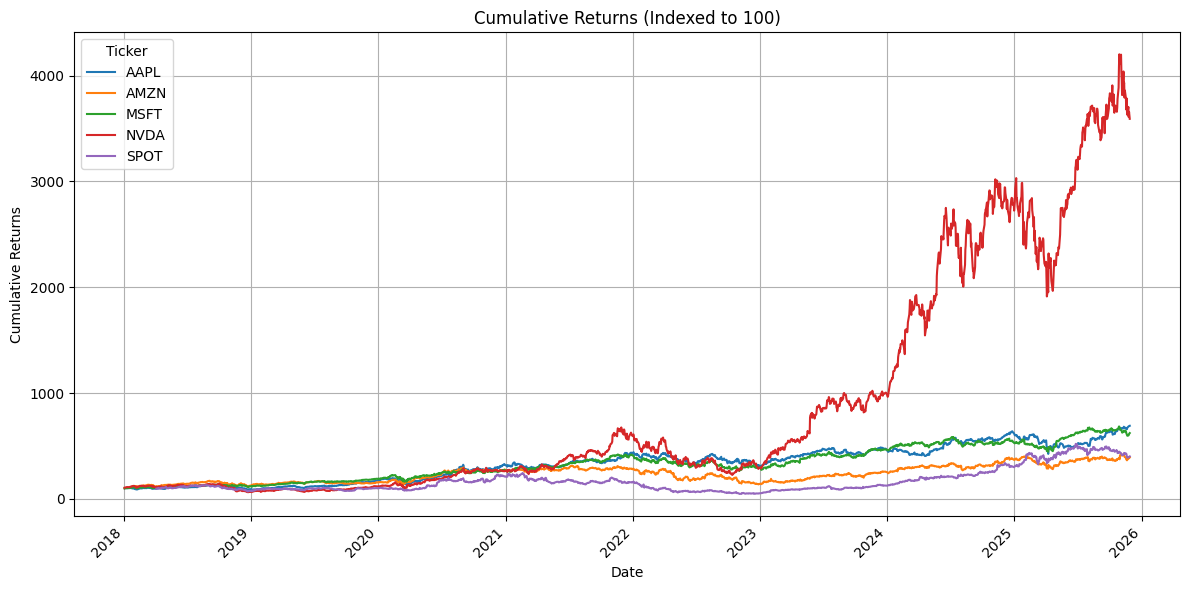

In [19]:
# Plot cumulative returns for all five stocks over the full sample period
plot_cumulative_returns(cumulative_returns, figsize=(12, 6))

## Comparing selected stocks

The full cumulative returns chart shows the overall growth of all five names,
but it can be difficult to see differences when many lines overlap.

To make the comparison clearer, I focus on three stocks:

- **AAPL** – a large, established tech company  
- **MSFT** – another mega-cap with steady compounding  
- **NVDA** – a high-growth, more volatile semiconductor stock  

By plotting only these three, it becomes easier to compare how a "classic" tech profile
(AAPL, MSFT) differs from a more aggressive growth stock (NVDA) over the same period.

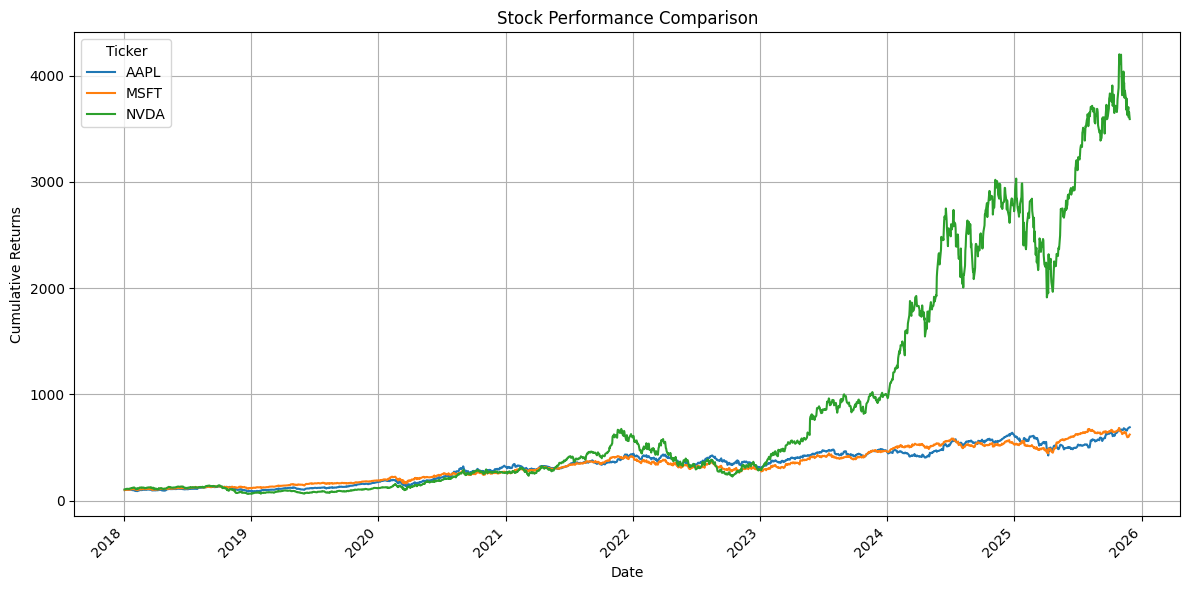

In [20]:
# Compare cumulative returns for a subset of stocks
focus_tickers = ["AAPL", "MSFT", "NVDA"]

plot_stock_comparison(
    cumulative_returns,
    tickers=focus_tickers,
    figsize=(12, 6),
)

## Rolling volatility during market shocks

To study how risk evolves over time, I compute a **21-day rolling, annualised volatility**
for each stock. This smooths out day-to-day noise and shows when each company becomes
more or less volatile.

Plotting all five stocks and events on a single chart becomes hard to read, so I split the
visualisation into two panels:

- One panel for **AAPL, MSFT, NVDA** (larger, more established tech names)
- One panel for **AMZN, SPOT** (e-commerce and streaming platform, with different risk profiles)

In both charts, I highlight key market stress periods (COVID-19 crash and the 2022 inflation-driven selloff).

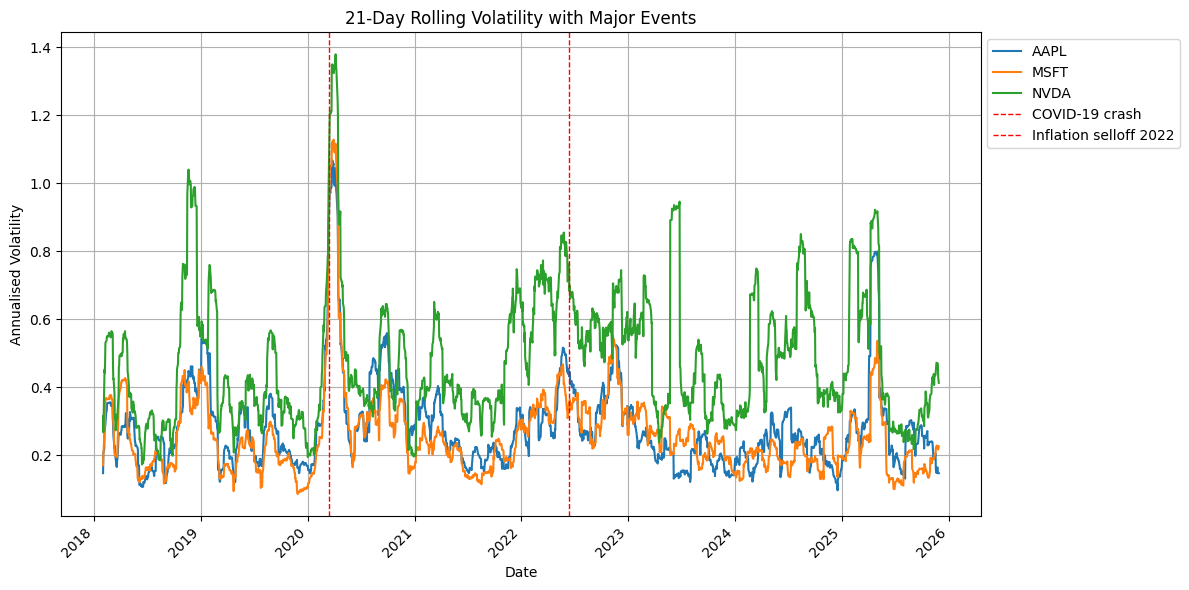

In [28]:
# Define major market events to highlight on the volatility charts
event_dates = {
    "COVID-19 crash": "2020-03-16",
    "Inflation selloff 2022": "2022-06-13",
}

# Panel 1: larger, more established tech names
rolling_vol_large = rolling_volatility[["AAPL", "MSFT", "NVDA"]]

plot_volatility_with_events(
    rolling_vol_large,
    event_dates=event_dates,
    figsize=(12, 6),
)

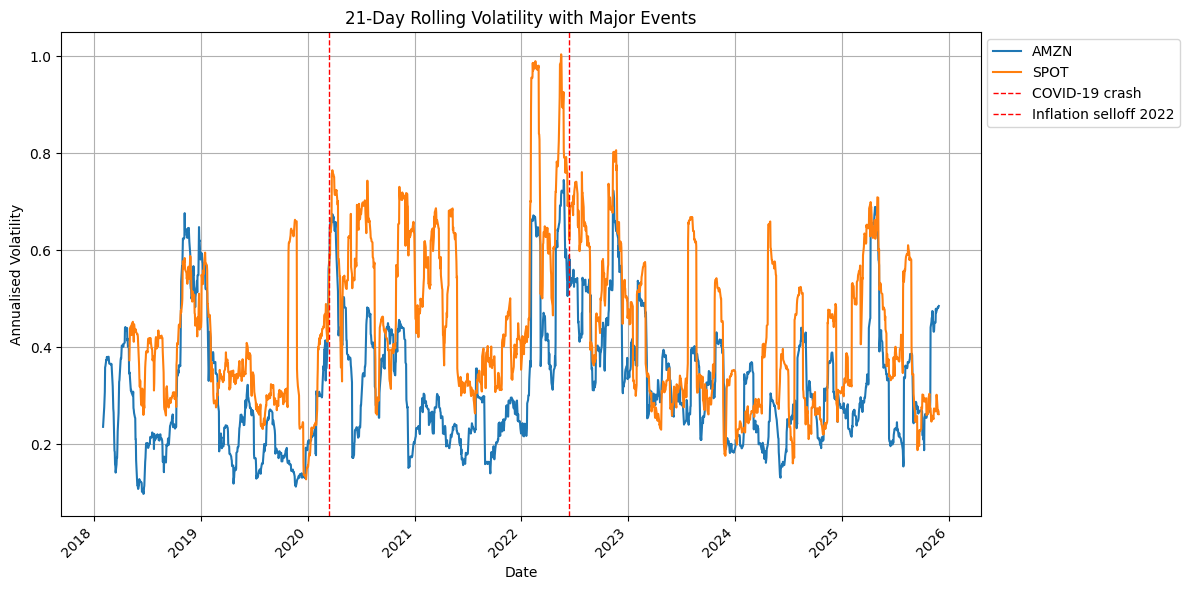

In [29]:
# Panel 2: platform/consumer names (Amazon and Spotify)
rolling_vol_platforms = rolling_volatility[["AMZN", "SPOT"]]

plot_volatility_with_events(
    rolling_vol_platforms,
    event_dates=event_dates,
    figsize=(12, 6),
)

### Interpreting Rolling Volatility During Market Stress

The two panels above show how the **21-day annualised volatility** evolved for the selected stocks.
Volatility measures how sharply prices fluctuate; higher values indicate greater uncertainty and risk.

#### Key observations:

**1. COVID-19 Crash (March 2020)**
- All stocks experience a **sharp spike in volatility**, reflecting the sudden market shock.
- NVDA and AMZN show the **largest jump**, suggesting they were more sensitive to pandemic-driven uncertainty.
- AAPL and MSFT remain relatively more stable, reflecting their size and diversified business models.

**2. Inflation-Driven Selloff (2022)**
- Another clear volatility surge appears around mid-2022.
- NVDA again stands out with **higher volatility**, linked to sharp corrections in semiconductor and growth stocks.
- SPOT shows the most persistent elevation in volatility, consistent with weaker profitability during that period.

**3. Differences between stock groups**
- **Large megacaps (AAPL, MSFT)**: Volatility remains the lowest over most of the period.  
  These companies act as “relative safe havens” within the tech sector.
- **High-growth names (NVDA, AMZN)**: Larger swings, especially in stressed markets.
- **SPOT**: Shows the most irregular volatility pattern — typical for younger, less diversified, and less profitable tech firms.

Overall, these plots illustrate that **market shocks do not impact all tech companies equally**.  
Larger, established firms experience **shorter and milder volatility spikes**, while high-growth and unprofitable companies show  
**deeper, more extended volatility episodes** during the same events.

## Drawdowns: Measuring Declines From Prior Peaks

While volatility shows how *fast* prices move, **drawdowns** measure how *far* prices fall from their previous highs.  
This metric helps capture real downside risk during market stress events.

A drawdown of:
- `0` → the stock is at a new peak  
- `-0.20` → the stock is 20% below its previous peak  
- `-0.50` → the stock is 50% below its peak (a deep correction)

Below, I compute the drawdowns for each stock and examine the periods where declines were the most severe.

In [30]:
# Compute drawdowns from cumulative returns
drawdowns = compute_drawdowns(cumulative_returns)

# Preview the first valid drawdown values
drawdowns.dropna().head()

Ticker,AAPL,AMZN,MSFT,NVDA,SPOT
Date,,,,,
2018-04-04,-0.055635,-0.117506,-0.045882,-0.096774,0.000000
2018-04-05,-0.049087,-0.091742,-0.045366,-0.116177,-0.001595
2018-04-06,-0.073410,-0.120847,-0.067583,-0.144642,0.000000
2018-04-09,-0.064220,-0.120315,-0.062003,-0.140011,0.000000
2018-04-10,-0.046610,-0.101458,-0.040198,-0.090107,0.000000


### Visualising Drawdowns During Recent Market Shocks

To better understand downside risk, I now plot the drawdowns from **2020 onwards**,  
covering both the COVID-19 crash and the later inflation-driven selloff.

Focusing on this period keeps the chart readable while highlighting how far each stock fell below its previous peak.

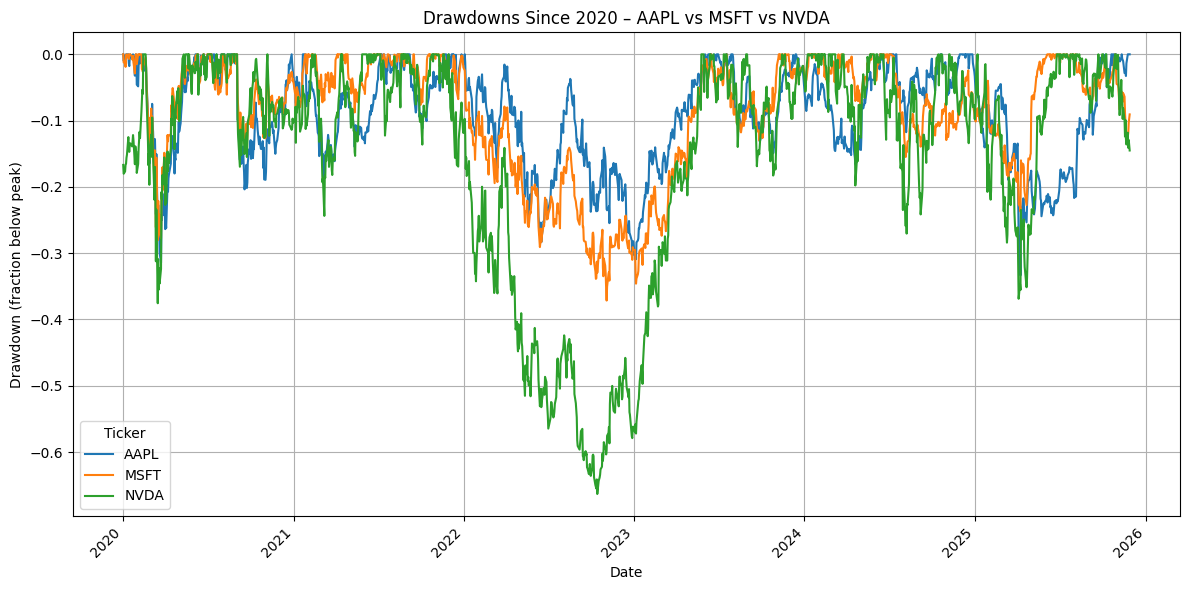

In [32]:
# Focus on the drawdowns since 2020 (COVID + inflation selloff)
drawdowns_shocks = drawdowns.loc["2020-01-01":]

# Plot drawdowns for a subset of stocks to keep the chart readable
subset_tickers = ["AAPL", "MSFT", "NVDA"]

ax = drawdowns_shocks[subset_tickers].plot(
    figsize=(12, 6),
    title="Drawdowns Since 2020 – AAPL vs MSFT vs NVDA",
)

ax.set_xlabel("Date")
ax.set_ylabel("Drawdown (fraction below peak)")
ax.grid(True)

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Drawdowns Since 2020: Comparing AAPL, MSFT, and NVDA

The chart above shows **drawdowns** for three major tech stocks — Apple, Microsoft, and Nvidia — starting from January 2020.  
A drawdown measures how far a stock falls below its previous peak.  
- A value of **0** means the stock is at (or near) an all-time high.  
- A value of **–0.40** means the stock is **40% below its previous peak**.

#### Key observations:

**1. COVID-19 Crash (March 2020)**  
All three stocks fell rapidly during the COVID-19 market shock.  
- **NVDA experienced the deepest and fastest drop**, reflecting the higher sensitivity of semiconductor and growth stocks.  
- **AAPL and MSFT recovered more quickly**, consistent with their more stable earnings and diversified operations.

**2. Inflation-Driven Selloff (2022)**  
Around mid-2022, all three stocks faced another significant decline.  
- **NVDA again shows the largest drawdown**, aligned with the sharp selloff in high-valuation tech.  
- **AAPL and MSFT remained more resilient**, with smaller and shorter-lived declines.

**3. Relative resilience**  
- AAPL and MSFT behave like **defensive megacaps** within tech — they fall during crises but recover faster.  
- NVDA behaves more like a **high-beta growth stock**, showing both higher upside and deeper downside.

This comparison highlights how company size, business model, and investor expectations shape downside risk during market stress.

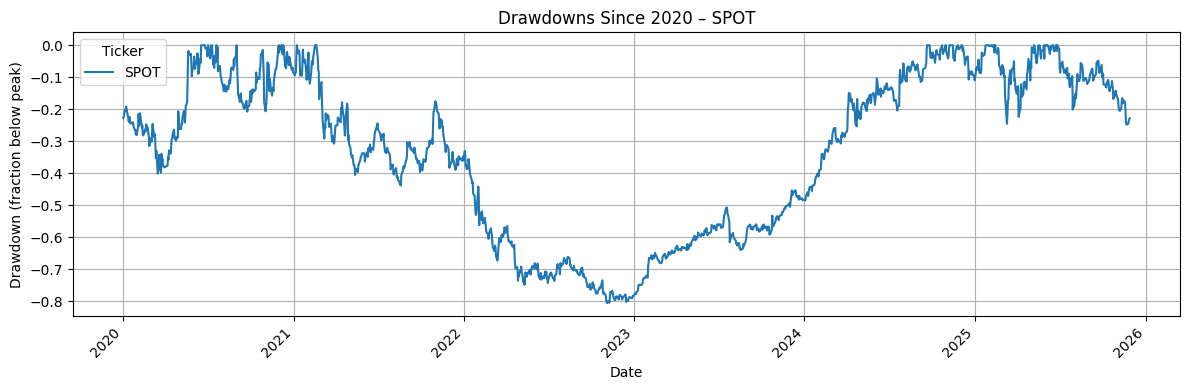

In [33]:
# Separate plot for Spotify to highlight its more volatile profile
ax = drawdowns_shocks[["SPOT"]].plot(
    figsize=(12, 4),
    title="Drawdowns Since 2020 – SPOT",
)

ax.set_xlabel("Date")
ax.set_ylabel("Drawdown (fraction below peak)")
ax.grid(True)

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Drawdowns Since 2020: Spotify (SPOT)

Spotify is shown separately because its drawdown behavior is much more extreme than the megacap stocks.

#### What we observe:

**1. Severe drawdowns during COVID and especially 2022**  
SPOT experiences multiple periods where it falls **50–80% below its previous peak**.  
This is dramatically deeper than AAPL, MSFT, or even NVDA.

**2. Slow and inconsistent recovery**  
Unlike the megacaps, which tend to rebound after market shocks, Spotify’s drawdown curve remains depressed for long periods.  
This reflects:
- A less diversified business model  
- Limited profitability  
- Higher sensitivity to investor sentiment around growth companies

**3. High-risk profile**  
Spotify demonstrates the characteristics of a **high-volatility, high-risk tech stock**:  
large swings, slow recoveries, and deeper downside during market stress.

Plotting SPOT separately provides a clearer comparison and avoids cluttering the multi-stock chart.

In [38]:
# Compute the maximum drawdown (most negative value) for each stock since 2020
max_drawdowns = drawdowns_shocks.min().sort_values()

max_drawdowns

Ticker
SPOT   -0.805124
NVDA   -0.663351
AMZN   -0.561453
MSFT   -0.371485
AAPL   -0.333605
dtype: float64

### Maximum Drawdowns Since 2020

The table above shows the **maximum drawdown** for each stock since 2020.  
A drawdown measures how far a stock fell from its previous peak, expressed as a fraction:

- A value of `-0.30` means the stock was at some point **30% below its prior peak**.
- A value of `-0.50` means a **50% drop** from the highest level reached up to that date.

This summary complements the drawdown plots:

- It **quantifies** the worst loss each stock experienced during the COVID shock and the 2022 selloff.
- It allows a direct comparison of downside risk between stocks, independent of their long-term growth.

In the context of this project, stocks with **shallower maximum drawdowns** can be seen as more resilient during market stress,
while those with **deeper drawdowns** were more vulnerable to sharp corrections.